<a href="https://colab.research.google.com/github/kanri3/deep_learning_day3_day4/blob/main/3_3_predict_sin_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# predict sin

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### [try]
-  iters_numを100にしよう
-  maxlenを5, iters_numを500, 3000(※時間がかかる)にしよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

0 loss: 6.400554913461295e-07    d: [-0.47157024]    y: [-0.47270166]
10 loss: 2.519274083210892e-07    d: [0.39789889]    y: [0.39860872]
20 loss: 1.5657059774471962e-06    d: [0.44921588]    y: [0.45098546]
30 loss: 2.018077097022776e-06    d: [-0.64813056]    y: [-0.65013957]
40 loss: 4.329262087344701e-08    d: [0.99975723]    y: [1.00005149]
50 loss: 1.1290738018676499e-07    d: [-0.75948523]    y: [-0.75901003]
60 loss: 2.0213901280512264e-06    d: [-0.94789551]    y: [-0.94990618]
70 loss: 9.354149663471122e-08    d: [0.35120641]    y: [0.35163894]
80 loss: 2.3014107038179637e-06    d: [0.16296018]    y: [0.1651056]
90 loss: 9.048861957161455e-08    d: [0.98714074]    y: [0.98671532]


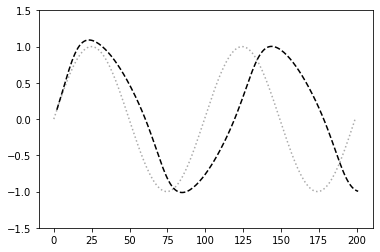

In [ ]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 2

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 300
# iters_num = 500

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    if s % 10 == 0:
      print(s, 'loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()